# NAWI Alliance Spring Meeting 2023: 
# Interactive Code Demonstration Using WaterTAP

### Today's demonstration will show 
- Part 1: how to build, initialize, simulate, and optimize a nanofiltration (NF) unit model based on the Donnan Steric Pore Model with Dielectric Exclusion (DSPM-DE).
- Part 2: repeat the same process for an NF flowsheet with bypass.
- Part 3: demonstrate the same NF flowsheet in WaterTAP's graphical user interface, which is in early stages of development.

# Part 1: Build, setup, simulate, and optimize the NF DSPM-DE unit model

<img src="nf_dspmde_transport_mechanisms.png" width="500" height="340">
Image source: <a href="https://doi.org/10.1016/j.desal.2017.07.020">Roy et al., 2017</a>


## Step 1: Import libraries from Pyomo, IDAES, and WaterTAP.

In [1]:
# Imports from Pyomo, including "value" for getting the value of Pyomo objects
from pyomo.environ import ConcreteModel, Constraint, Objective, Expression, value, units as pyunits, assert_optimal_termination
# Imports from IDAES:
# Import flowsheet block from IDAES core
from idaes.core import FlowsheetBlock
# Import function to get default solver
from idaes.core.solvers import get_solver
# Import function to check degrees of freedom
from idaes.core.util.model_statistics import degrees_of_freedom
# Import utility function for calculating scaling factors
from idaes.core.util.scaling import calculate_scaling_factors, set_scaling_factor

### Importing the multicomponent property model and NF DSPM-DE unit model, along with configuration options for each.

In [2]:
# Imports from WaterTAP
# Import MultiComponent Aqueous Solution property model
from watertap.property_models.multicomp_aq_sol_prop_pack import (MCASParameterBlock, 
                                                                 ActivityCoefficientModel,
                                                                 DensityCalculation,)
# Import NF DSPM-DE model
from watertap.unit_models.nanofiltration_DSPMDE_0D import (
    NanofiltrationDSPMDE0D,
    MassTransferCoefficient,
    ConcentrationPolarizationType,
)

## Step 2: Start building the NF DSPM-DE model.

In [3]:
# Create a Pyomo concrete model, flowsheet, and set up solute properties required by the DSPM-DE model.
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

property_kwds = {
"solute_list": [
    "Ca_2+",
    "SO4_2-",
    "HCO3_-",
    "Na_+",
    "Cl_-",
],
"diffusivity_data": {
    ("Liq", "Ca_2+"): 9.2e-10,
    ("Liq", "SO4_2-"): 1.06e-9,
    ("Liq", "HCO3_-"): 1.19e-9,
    ("Liq", "Na_+"): 1.33e-9,
    ("Liq", "Cl_-"): 2.03e-9,
},
"mw_data": {
    "H2O": 18e-3,
    "Ca_2+": 40e-3,
    "HCO3_-": 61.0168e-3,
    "SO4_2-": 96e-3,
    "Na_+": 23e-3,
    "Cl_-": 35e-3,
},
"stokes_radius_data": {
    "Ca_2+": 0.309e-9,
    "HCO3_-": 2.06e-10,
    "SO4_2-": 0.230e-9,
    "Cl_-": 0.121e-9,
    "Na_+": 0.184e-9,
},
"charge": {
    "Ca_2+": 2,
    "HCO3_-": -1,
    "SO4_2-": -2,
    "Na_+": 1,
    "Cl_-": -1,
},
"activity_coefficient_model": ActivityCoefficientModel.ideal,
"density_calculation": DensityCalculation.constant,
}

m.fs.properties = MCASParameterBlock(**property_kwds)

In [4]:
# Add an NF DSPM-DE unit to the flowsheet.
m.fs.unit = NanofiltrationDSPMDE0D(property_package=m.fs.properties)

## Step 3: Specify values for system variables.

### Fix mole flow rates of each ion and water


In [5]:
mass_flow_in = 1 * pyunits.kg / pyunits.s
feed_mass_frac = {
    "Ca_2+": 4.0034374454637006e-04,
    "HCO3_-": 0.00022696833343821863,
    "SO4_2-": 0.00020497140244420624,
    "Cl_-": 0.0004559124032433401,
    "Na_+": 0.00043333830389924205,
}

for ion, x in feed_mass_frac.items():
    mol_comp_flow = (
        x
        * pyunits.kg
        / pyunits.kg
        * mass_flow_in
        / m.fs.unit.feed_side.properties_in[0].mw_comp[ion]
    )
    m.fs.unit.inlet.flow_mol_phase_comp[0, "Liq", ion].fix(mol_comp_flow)
    
H2O_mass_frac = 1 - sum(x for x in feed_mass_frac.values())
H2O_mol_comp_flow = (
    H2O_mass_frac
    * pyunits.kg
    / pyunits.kg
    * mass_flow_in
    / m.fs.unit.feed_side.properties_in[0].mw_comp["H2O"]
)
m.fs.unit.inlet.flow_mol_phase_comp[0, "Liq", "H2O"].fix(H2O_mol_comp_flow)

In [6]:
for j in m.fs.properties.component_list:
    print(f"{j}= {value(m.fs.unit.inlet.flow_mol_phase_comp[0, 'Liq', j])}")

H2O= 55.45991476735715
Ca_2+= 0.010008593613659252
SO4_2-= 0.0021351187754604815
HCO3_-= 0.003719767890781205
Na_+= 0.018840795821706176
Cl_-= 0.01302606866409543


### Use assert_electroneutrality method from property model to ensure the ion concentrations provided obey electroneutrality condition

In [7]:
m.fs.unit.feed_side.properties_in[0].assert_electroneutrality(
    defined_state=True,
    adjust_by_ion="Cl_-",
    get_property="mass_frac_phase_comp",
)

{Member of conc_mol_phase_comp} : Molar concentration
    Size=6, Index=fs.unit.feed_side.properties_in[0.0].conc_mol_phase_comp_index, Units=mol/m**3
    Key            : Lower : Value             : Upper : Fixed : Stale : Domain
    ('Liq', 'H2O') :     0 : 55425.30350471729 :  None : False : False :  Reals
{Member of conc_mol_phase_comp} : Molar concentration
    Size=6, Index=fs.unit.feed_side.properties_in[0.0].conc_mol_phase_comp_index, Units=mol/m**3
    Key              : Lower : Value              : Upper : Fixed : Stale : Domain
    ('Liq', 'Ca_2+') :     0 : 10.002347479606016 :  None : False : False :  Reals
{Member of conc_mol_phase_comp} : Molar concentration
    Size=6, Index=fs.unit.feed_side.properties_in[0.0].conc_mol_phase_comp_index, Units=mol/m**3
    Key               : Lower : Value              : Upper : Fixed : Stale : Domain
    ('Liq', 'SO4_2-') :     0 : 2.1337862967321106 :  None : False : False :  Reals
{Member of conc_mol_phase_comp} : Molar concentration

### Fix other inlet state variables


In [8]:
m.fs.unit.inlet.temperature[0].fix(298.15)
m.fs.unit.inlet.pressure[0].fix(4e5)

### Fix the membrane variables that are usually fixed for the DSPM-DE model

In [9]:
m.fs.unit.radius_pore.fix(0.5e-9)
m.fs.unit.membrane_thickness_effective.fix(8.6e-07)
m.fs.unit.membrane_charge_density.fix(-680)
m.fs.unit.dielectric_constant_pore.fix(41.3)

# Fix final permeate pressure to be ~atmospheric
m.fs.unit.mixed_permeate[0].pressure.fix(101325)

m.fs.unit.spacer_porosity.fix(0.85)
m.fs.unit.channel_height.fix(1e-3)
m.fs.unit.velocity[0, 0].fix(0.25)
m.fs.unit.area.fix(50)

# Fix additional variables for calculating mass transfer coefficient with spiral wound correlation
m.fs.unit.spacer_mixing_efficiency.fix()
m.fs.unit.spacer_mixing_length.fix()

In [10]:
m.fs.unit.feed_side.properties_in[0].total_hardness

## Step 4: Scale all variables.

In [11]:
# Calculate scaling factors for variables.
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e4, index=("Liq", "Ca_2+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e3, index=("Liq", "SO4_2-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e3, index=("Liq", "HCO3_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e2, index=("Liq", "Cl_-"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e2, index=("Liq", "Na_+"))
m.fs.properties.set_default_scaling("flow_mol_phase_comp", 1e0, index=("Liq", "H2O"))
calculate_scaling_factors(m);

2023-05-23 04:46:14 [WARNING] idaes.core.util.scaling: Missing scaling factor for fs.unit.area


## Step 5: Initialize the model.

In [12]:
m.fs.unit.initialize()

2023-05-23 04:46:17 [INFO] idaes.init.fs.unit: Initialization Complete: optimal - Optimal Solution Found


## Step 6: Setup a solver and run a simulation.

In [13]:
# Check that degrees of freedom = 0 before attempting simulation.
# This means that the performance of the flowsheet is completely
# determined by the system variables that were fixed above.
assert degrees_of_freedom(m) == 0

In [14]:
# Setup solver
solver = get_solver()

In [15]:
# Run simulation
simulation_results = solver.solve(m)

In [16]:
# Display report, reports include a small subset of the most important variables
m.fs.unit.report()


Unit : fs.unit                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                                                           : Value      : Units                                        : Fixed : Bounds
                             Electric Potential @ Permeate, Inlet :   0.037047 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential @ Permeate, Outlet :   0.033780 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                        Electric Potential @ Pore Entrance, Inlet :   -0.11391 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                       Electric Potential @ Pore Entrance, Outlet :   -0.11278 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential @ Po

    Key                                                         : Value      : Units
                                    Average Mole FLux of Ca_2+  : 3.5692e-06 : mole / meter ** 2 / second
                                     Average Mole FLux of Cl_-  : 2.4496e-05 : mole / meter ** 2 / second
                                      Average Mole FLux of H2O  :    0.15646 : mole / meter ** 2 / second
                                   Average Mole FLux of HCO3_-  : 2.3135e-06 : mole / meter ** 2 / second
                                     Average Mole FLux of Na_+  : 1.9671e-05 : mole / meter ** 2 / second
                                   Average Mole FLux of SO4_2-  : 2.1854e-10 : mole / meter ** 2 / second
                                  Average Volumetric Flux (LMH) :     10.170 : meter / second
             Born Solvation Energy Partitioning Factor of Ca_2+ :   0.013960 : dimensionless
              Born Solvation Energy Partitioning Factor of Cl_- :   0.065409 : dimensionless

## Step 7: Unfix variables, set variable bounds, and run optimization to minimize specific energy consumption.

In [17]:
m.fs.unit.feed_side.properties_in[0].total_hardness.display()

total_hardness : total hardness as CaCO3
    Size=1, Index=None, Units=mg/l
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :     0 : 1001.1039519565792 :  None : False : False : NonNegativeReals


In [18]:
# Unfix membrane area and feed pressure
m.fs.unit.area.unfix()                  # membrane area (m^2)
m.fs.unit.inlet.pressure[0].unfix()     # feed pressure (Pa)

In [19]:
# Set lower and upper bounds for membrane area (m^2)
m.fs.unit.area.setlb(1)
m.fs.unit.area.setub(None)

In [20]:
# Set lower and upper bounds for feed pressure (Pa)
# m.fs.unit.inlet.pressure[0].setlb(10e5)
m.fs.unit.inlet.pressure[0].setub(80e5)

In [21]:
# Assume 100% efficiency of pumps and ERD and no pressure losses
#--> Pump power consumption ~ Qp*Pf/3.6e6
m.fs.specific_energy_consumption = Expression(
    expr=m.fs.unit.inlet.pressure[0]/(3.6e6))

In [22]:
# Define objective function to minimize the specific energy consumption.
m.fs.objective = Objective(expr=m.fs.specific_energy_consumption)

In [23]:
m.fs.max_hardness = Constraint(expr=m.fs.unit.mixed_permeate[0].total_hardness <= 500)

In [24]:
# Set the water recovery to 50%
m.fs.unit.recovery_vol_phase[0,'Liq'].fix(0.50)

In [25]:
# The solver will find the membrane area and 
# inlet pressure that achieve 50% recovery while minimizing
# specific energy consumption. Since we fixed the 
# volumetric water recovery, a degree of freedom 
# was removed from the model and is now 1.
print(degrees_of_freedom(m))

1


In [26]:
m.fs.unit.recovery_vol_phase[0,'Liq'].unfix()

In [27]:
# Solve the model
optimization_results = solver.solve(m, tee=True)


ipopt-watertap: Ipopt with user variable scaling and IDAES jacobian constraint scaling
Ipopt 3.13.2: tol=1e-08
constr_viol_tol=1e-08
nlp_scaling_method=user-scaling
bound_relax_factor=0.0


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the

  77  6.0587322e-02 2.67e-01 4.07e+03  -3.8 1.69e+02    -  7.75e-01 5.31e-04h  1
  78  6.0586793e-02 2.67e-01 7.40e+07  -3.8 1.46e+03    -  4.15e-01 2.61e-05h  1
  79  6.0585686e-02 2.67e-01 5.05e+11  -3.8 1.30e+03    -  4.48e-01 5.46e-05h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80r 6.0585686e-02 2.67e-01 1.00e+03  -1.9 0.00e+00    -  0.00e+00 2.71e-07R  4
  81r 6.0365625e-02 4.04e-02 9.97e+02  -1.9 3.43e+02    -  5.57e-03 1.09e-03f  1
  82  6.0365890e-02 4.04e-02 1.27e+04  -3.8 1.70e+02    -  7.74e-01 1.69e-04h  1
  83r 6.0365890e-02 4.04e-02 1.00e+03  -2.1 0.00e+00    -  0.00e+00 4.24e-07R  5
  84r 6.0349004e-02 1.06e-02 9.95e+02  -2.1 4.23e+02    -  1.49e-02 2.20e-03f  1
  85  6.0349359e-02 1.06e-02 1.02e+04  -3.8 1.79e+02    -  7.85e-01 2.13e-04h  1
  86  6.0349013e-02 1.06e-02 2.75e+08  -3.8 1.46e+03    -  4.16e-01 1.68e-05h  1
  87  6.0348628e-02 1.06e-02 6.16e+12  -3.8 1.36e+03    -  4.38e-01 1.87e-05h  1
In iteration 87, 1 Slack too

 189  8.3327204e-02 6.29e+01 4.89e+09  -3.8 5.36e+01    -  5.54e-01 5.54e-01s 16
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190  8.3821604e-02 1.40e+01 8.50e+08  -3.8 6.42e+01    -  9.21e-01 9.21e-01s 16
 191  8.3644758e-02 1.34e+01 8.16e+08  -3.8 8.48e+02    -  4.01e-02 4.01e-02s 16
 192r 8.3644758e-02 1.34e+01 1.00e+03   0.0 0.00e+00    -  0.00e+00 0.00e+00R  1
 193r 8.3862006e-02 2.18e-01 2.11e+04   0.0 1.02e+03    -  2.45e-03 9.99e-04f  1
 194r 8.3942879e-02 2.54e-01 2.12e+04   0.0 3.80e+01    -  1.37e-03 3.77e-03f  1
 195r 8.4008037e-02 2.33e-01 1.93e+04   0.0 1.05e+01    -  1.83e-02 7.11e-03f  1
 196  8.4030850e-02 1.99e-01 8.14e+01  -3.8 2.93e+00    -  9.82e-01 1.45e-01h  1
 197  8.4610456e-02 1.74e-01 2.10e+04  -3.8 1.93e+02    -  7.53e-01 6.25e-02h  5
 198  8.4727850e-02 1.71e-01 7.41e+03  -3.8 1.90e+02    -  8.35e-01 1.56e-02h  7
 199  8.4796546e-02 1.68e-01 1.55e+03  -3.8 1.98e+02    -  9.01e-01 1.56e-02h  7
iter    objective    inf_pr 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290  8.6736917e-02 9.06e-02 2.40e+04  -3.8 2.35e+02    -  1.00e+00 7.65e-03h  8
 291  8.6773888e-02 8.99e-02 2.46e+04  -3.8 2.35e+02    -  1.00e+00 7.65e-03h  8
 292  8.6811182e-02 8.92e-02 2.53e+04  -3.8 2.35e+02    -  1.00e+00 7.65e-03h  8
 293  8.6848800e-02 8.84e-02 2.60e+04  -3.8 2.36e+02    -  1.00e+00 7.65e-03h  8
 294  8.6886746e-02 8.77e-02 2.67e+04  -3.8 2.36e+02    -  1.00e+00 7.65e-03h  8
 295  8.6925023e-02 8.70e-02 2.74e+04  -3.8 2.36e+02    -  1.00e+00 7.65e-03h  8
 296  8.6963634e-02 8.63e-02 2.81e+04  -3.8 2.36e+02    -  1.00e+00 7.65e-03h  8
 297  8.7002583e-02 8.56e-02 2.88e+04  -3.8 2.37e+02    -  1.00e+00 7.65e-03h  8
 298  9.2031537e-02 5.50e+00 8.48e+03  -3.8 2.37e+02    -  1.00e+00 9.79e-01w  1
 299  9.1315634e-02 5.15e+00 1.37e+06  -3.8 1.60e+02  -6.0 1.00e+00 6.43e-02w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300  6.8806510e-02 1.12e+01

 403  9.8676239e-02 4.77e+00 1.70e+06  -3.8 1.28e+02  -5.9 1.00e+00 1.75e-01w  1
 404  9.6920598e-02 4.49e+00 4.10e+05  -3.8 3.80e+02  -6.4 1.00e+00 6.05e-02w  1
 405  9.1125319e-02 4.36e-02 1.58e+05  -3.8 1.08e+03    -  1.00e+00 3.85e-03h  8
 406  9.1163529e-02 4.34e-02 1.61e+05  -3.8 2.43e+02    -  1.00e+00 3.85e-03h  9
 407  9.1201921e-02 4.32e-02 1.63e+05  -3.8 2.43e+02    -  1.00e+00 3.85e-03h  9
 408  9.1240495e-02 4.30e-02 1.66e+05  -3.8 2.43e+02    -  1.00e+00 3.85e-03h  9
 409  9.1279253e-02 4.28e-02 1.69e+05  -3.8 2.43e+02    -  1.00e+00 3.85e-03h  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 410  9.1318195e-02 4.26e-02 1.71e+05  -3.8 2.43e+02    -  1.00e+00 3.85e-03h  9
 411  9.1357323e-02 4.24e-02 1.74e+05  -3.8 2.43e+02    -  1.00e+00 3.86e-03h  9
 412  9.1396638e-02 4.22e-02 1.77e+05  -3.8 2.43e+02    -  1.00e+00 3.86e-03h  9
 413  9.1436141e-02 4.20e-02 1.80e+05  -3.8 2.43e+02    -  1.00e+00 3.86e-03h  9
 414  9.1475833e-02 4.18e-02

 515  9.5222621e-02 3.37e-02 5.82e+04  -3.8 2.38e+02    -  1.00e+00 3.79e-03h  9
 516  9.5260454e-02 3.36e-02 6.79e+04  -3.8 2.38e+02    -  1.00e+00 1.90e-03h 10
 517  9.5299086e-02 3.36e-02 7.62e+04  -3.8 2.38e+02    -  1.00e+00 1.92e-03h 10
 518  9.5338169e-02 3.35e-02 8.30e+04  -3.8 2.38e+02    -  1.00e+00 1.92e-03h 10
 519  1.1561725e-01 7.25e+00 4.77e+04  -3.8 2.38e+02    -  1.00e+00 9.86e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 520  1.1562109e-01 6.88e+00 4.49e+04  -3.8 5.69e+01    -  7.29e-01 5.35e-02w  1
 521  1.1561445e-01 6.88e+00 1.17e+06  -3.8 2.64e+02    -  1.00e+00 1.91e-04w  1
 522  9.5377776e-02 3.35e-02 8.86e+04  -3.8 9.20e+02    -  1.00e+00 1.93e-03h  9
 523  9.5417835e-02 3.34e-02 9.31e+04  -3.8 2.38e+02    -  1.00e+00 1.93e-03h 10
 524  9.5458314e-02 3.34e-02 9.67e+04  -3.8 2.38e+02    -  1.00e+00 1.93e-03h 10
 525  9.5499189e-02 3.34e-02 9.96e+04  -3.8 2.38e+02    -  1.00e+00 1.94e-03h 10
 526  9.5540429e-02 3.33e-02

 629  9.9167758e-02 3.02e-02 9.75e+04  -3.8 2.46e+02    -  6.84e-01 9.61e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 630  9.9201466e-02 3.02e-02 9.75e+04  -3.8 2.53e+02    -  1.00e+00 9.77e-04h 11
 631  9.9234109e-02 3.02e-02 9.74e+04  -3.8 2.48e+02    -  6.75e-01 9.61e-04h 11
 632  9.9268074e-02 3.02e-02 9.73e+04  -3.8 2.55e+02    -  1.00e+00 9.77e-04h 11
 633  9.9300973e-02 3.01e-02 9.72e+04  -3.8 2.50e+02    -  6.65e-01 9.61e-04h 11
 634  9.9335198e-02 3.01e-02 9.71e+04  -3.8 2.57e+02    -  1.00e+00 9.77e-04h 11
 635  9.9368355e-02 3.01e-02 9.70e+04  -3.8 2.51e+02    -  6.56e-01 9.61e-04h 11
 636  1.3468552e-01 1.36e+01 7.09e+04  -3.8 2.59e+02    -  1.00e+00 1.00e+00w  1
 637  1.5702922e-01 2.62e+01 7.10e+05  -3.8 3.33e+02    -  1.62e-01 2.58e-01w  1
 638  1.6480941e-01 1.96e+01 2.59e+07  -3.8 2.20e+02  -5.8 9.57e-01 5.04e-01w  1
 639  9.9402845e-02 3.01e-02 9.69e+04  -3.8 1.07e+02    -  1.00e+00 9.77e-04h 10
iter    objective    inf_pr 

 764  1.0287206e-01 2.80e-02 8.98e+04  -3.8 3.72e+02    -  1.00e+00 4.77e-04h 12
 765  1.0289707e-01 2.80e-02 8.97e+04  -3.8 3.67e+02    -  3.61e-01 4.80e-04h 12
 766  1.5441718e-01 2.81e+01 8.29e+04  -3.8 3.74e+02    -  1.00e+00 9.73e-01w  1
 767  1.5436672e-01 2.76e+01 2.80e+05  -3.8 1.76e+02    -  5.96e-01 1.62e-02w  1
 768  1.5211462e-01 2.63e+01 2.67e+05  -3.8 2.19e+02    -  7.00e-04 5.10e-02w  1
 769  1.0292222e-01 2.80e-02 8.97e+04  -3.8 2.80e+02    -  1.00e+00 4.75e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 770  1.0294731e-01 2.80e-02 8.97e+04  -3.8 3.69e+02    -  3.59e-01 4.78e-04h 12
 771  1.0297252e-01 2.80e-02 8.96e+04  -3.8 3.76e+02    -  1.00e+00 4.73e-04h 12
 772  1.0299766e-01 2.80e-02 8.96e+04  -3.8 3.71e+02    -  3.56e-01 4.77e-04h 12
 773  1.0302292e-01 2.79e-02 8.95e+04  -3.8 3.78e+02    -  1.00e+00 4.72e-04h 12
 774  1.0304811e-01 2.79e-02 8.95e+04  -3.8 3.73e+02    -  3.54e-01 4.75e-04h 12
 775  1.0307343e-01 2.79e-02

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 900  1.0557644e-01 2.69e-02 1.81e+05  -3.8 4.31e+02    -  2.98e-01 4.17e-04h 12
 901  1.0560357e-01 2.69e-02 2.12e+05  -3.8 4.31e+02    -  1.00e+00 4.17e-04h 12
 902  1.0563074e-01 2.68e-02 2.22e+05  -3.8 4.32e+02    -  2.97e-01 4.16e-04h 12
 903  1.0565792e-01 2.68e-02 2.61e+05  -3.8 4.32e+02    -  1.00e+00 4.16e-04h 12
 904  1.0568512e-01 2.68e-02 2.74e+05  -3.8 4.33e+02    -  2.96e-01 4.15e-04h 12
 905  1.0571233e-01 2.68e-02 3.23e+05  -3.8 4.33e+02    -  1.00e+00 4.15e-04h 12
 906  1.0573958e-01 2.68e-02 3.39e+05  -3.8 4.34e+02    -  2.95e-01 4.14e-04h 12
 907  1.0576683e-01 2.68e-02 4.01e+05  -3.8 4.34e+02    -  1.00e+00 4.14e-04h 12
 908  1.0579411e-01 2.68e-02 4.22e+05  -3.8 4.35e+02    -  2.94e-01 4.13e-04h 12
 909  1.6167140e-01 3.05e+01 7.65e+06  -3.8 4.35e+02    -  1.00e+00 8.45e-01w  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 910  1.6166925e-01 3.05e+01

1012  1.0803993e-01 2.60e-02 6.64e+10  -3.8 5.54e+02    -  2.13e-01 3.38e-04h 12
1013  1.6875260e-01 3.44e+01 7.64e+11  -3.8 5.52e+02    -  1.00e+00 6.93e-01w  1
1014  1.6379928e-01 3.10e+01 6.82e+11  -3.8 2.30e+02    -  1.94e-01 1.06e-01w  1
1015  1.6388379e-01 3.03e+01 6.75e+11  -3.8 1.96e+02    -  9.81e-02 2.47e-02w  1
1016  1.0806957e-01 2.60e-02 6.73e+10  -3.8 1.94e+02    -  1.00e+00 3.39e-04h 11
1017  1.0809922e-01 2.60e-02 6.74e+10  -3.8 5.51e+02    -  2.15e-01 3.39e-04h 12
1018  1.0812886e-01 2.60e-02 6.83e+10  -3.8 5.50e+02    -  1.00e+00 3.39e-04h 12
1019  1.0815850e-01 2.60e-02 6.84e+10  -3.8 5.49e+02    -  2.16e-01 3.39e-04h 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1020  1.0818814e-01 2.60e-02 6.93e+10  -3.8 5.48e+02    -  1.00e+00 3.40e-04h 12
1021  1.0821778e-01 2.60e-02 6.94e+10  -3.8 5.46e+02    -  2.18e-01 3.40e-04h 12
1022  1.0824742e-01 2.60e-02 7.03e+10  -3.8 5.45e+02    -  1.00e+00 3.40e-04h 12
1023  1.0827706e-01 2.60e-02

1125  1.1024062e-01 2.54e-02 1.12e+11  -3.8 4.20e+02    -  3.27e-01 5.24e-04h 11
1126  1.1027893e-01 2.54e-02 1.13e+11  -3.8 4.17e+02    -  1.00e+00 5.21e-04h 11
1127  1.1031678e-01 2.54e-02 1.13e+11  -3.8 4.14e+02    -  3.35e-01 5.17e-04h 11
1128  1.1035419e-01 2.54e-02 1.15e+11  -3.8 4.10e+02    -  1.00e+00 5.14e-04h 11
1129  1.1039114e-01 2.53e-02 1.15e+11  -3.8 4.07e+02    -  3.44e-01 5.11e-04h 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1130  1.4778923e-01 1.13e+01 6.71e+11  -3.8 4.04e+02    -  1.00e+00 5.20e-01w  1
1131  1.3284586e-01 1.01e+01 5.46e+11  -3.8 3.35e+02    -  2.77e-01 1.75e-01w  1
1132  1.3282655e-01 1.01e+01 5.45e+11  -3.8 3.28e+02    -  3.28e-01 2.34e-04w  1
1133  1.1042767e-01 2.53e-02 1.17e+11  -3.8 3.22e+02    -  1.00e+00 5.08e-04h 10
1134  1.1046376e-01 2.53e-02 1.17e+11  -3.8 4.01e+02    -  3.53e-01 5.04e-04h 11
1135  1.1049943e-01 2.53e-02 1.19e+11  -3.8 3.97e+02    -  1.00e+00 5.01e-04h 11
1136  1.1053468e-01 2.53e-02

1232  1.1325056e-01 2.43e-02 2.05e+11  -3.8 2.28e+02    -  1.00e+00 7.07e-04h 10
1233  1.1328510e-01 2.43e-02 2.06e+11  -3.8 2.27e+02    -  7.01e-01 7.04e-04h 10
1234  1.3076729e-01 1.90e+00 4.62e+11  -3.8 2.25e+02    -  1.00e+00 3.59e-01w  1
1235  1.1539571e-01 3.25e+00 2.96e+11  -3.8 5.01e+02    -  4.08e-01 1.22e-01w  1
1236  1.1538786e-01 3.25e+00 9.65e+11  -3.8 1.25e+03    -  2.30e-01 3.58e-05w  1
1237  1.1331925e-01 2.43e-02 2.07e+11  -3.8 1.08e+03    -  1.00e+00 7.01e-04h  9
1238  1.1335316e-01 2.43e-02 2.08e+11  -3.8 2.23e+02    -  7.16e-01 6.99e-04h 10
1239  1.1338665e-01 2.43e-02 2.10e+11  -3.8 2.21e+02    -  1.00e+00 6.96e-04h 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1240  1.1341987e-01 2.43e-02 2.11e+11  -3.8 2.19e+02    -  7.32e-01 6.93e-04h 10
1241  1.1345267e-01 2.43e-02 2.13e+11  -3.8 2.17e+02    -  1.00e+00 6.91e-04h 10
1242  1.1348516e-01 2.43e-02 2.14e+11  -3.8 2.17e+02    -  7.51e-01 6.88e-04h 10
1243  1.1351723e-01 2.42e-02

1349  1.1735181e-01 2.37e-02 2.18e+12  -3.8 1.87e+02    -  1.00e+00 3.55e-03h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1350  1.1741886e-01 2.37e-02 2.33e+12  -3.8 1.87e+02    -  1.00e+00 3.44e-03h  6
1351  1.1937844e-01 9.91e-02 2.22e+12  -3.8 1.86e+02    -  1.00e+00 1.07e-01w  1
1352  1.0753032e-01 1.05e+00 2.10e+13  -3.8 1.60e+03    -  2.44e-01 3.91e-02w  1
1353  1.0753032e-01 1.05e+00 2.02e+13  -3.8 8.40e-06  18.6 1.00e+00 1.20e-02w  1
1354  1.1748010e-01 2.37e-02 2.48e+12  -3.8 8.03e+02    -  1.00e+00 3.34e-03h  5
1355  1.1753570e-01 2.37e-02 2.65e+12  -3.8 1.85e+02    -  1.00e+00 3.24e-03h  6
1356  1.1758584e-01 2.37e-02 2.82e+12  -3.8 1.84e+02    -  1.00e+00 3.15e-03h  6
1357  1.1763069e-01 2.37e-02 3.01e+12  -3.8 1.83e+02    -  1.00e+00 3.05e-03h  6
1358  1.1767043e-01 2.37e-02 3.20e+12  -3.8 1.83e+02    -  1.00e+00 2.97e-03h  6
1359  1.1770522e-01 2.37e-02 3.41e+12  -3.8 1.82e+02    -  1.00e+00 2.88e-03h  6
iter    objective    inf_pr 

1455r 1.1164509e-01 2.09e-02 1.00e+03  -2.2 0.00e+00    -  0.00e+00 3.74e-07R  8
1456r 1.1165109e-01 1.61e-02 9.73e+02  -2.2 1.09e+02    -  7.29e-02 9.90e-04f  1
1457  1.1165108e-01 1.61e-02 2.80e+04  -3.8 2.87e+00    -  9.73e-01 1.63e-04h  1
1458r 1.1165108e-01 1.61e-02 1.00e+03  -2.8 0.00e+00    -  0.00e+00 4.07e-07R 14
1459r 1.1164561e-01 5.39e-03 9.77e+02  -2.8 2.44e+02    -  2.39e-02 9.91e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1460  1.1164561e-01 5.39e-03 1.12e+05  -3.8 3.02e+00    -  9.85e-01 4.13e-05h  1
1461  1.1164897e-01 5.39e-03 2.36e+06  -3.8 4.56e+03    -  6.31e-02 4.82e-06h 12
1462r 1.1164897e-01 5.39e-03 1.00e+03  -3.4 0.00e+00    -  0.00e+00 2.60e-07R 19
1463r 1.1164866e-01 3.08e-03 9.98e+02  -3.4 1.10e+02    -  4.52e-02 9.91e-04f  1
1464  1.1164866e-01 3.08e-03 4.43e+05  -3.8 2.84e+00    -  9.85e-01 1.05e-05h  1
1465  1.1164891e-01 3.08e-03 2.79e+06  -3.8 4.69e+03    -  6.16e-02 3.47e-07h 17
1466r 1.1164891e-01 3.08e-03

1583  4.6893848e-02 3.79e+00 8.28e+02  -8.6 3.76e+01    -  6.24e-01 6.41e-03h  7
1584  4.6912501e-02 3.76e+00 1.28e+03  -8.6 1.86e+01    -  8.85e-01 7.42e-03h  7
1585  4.6915948e-02 3.76e+00 2.23e+03  -8.6 1.47e+01    -  9.55e-01 1.90e-03h  9
1586  4.6916004e-02 3.76e+00 4.24e+03  -8.6 1.45e+01    -  9.99e-01 2.96e-05h 15
1587  4.7753231e-02 1.84e+00 1.65e+04  -8.6 1.46e+01    -  1.00e+00 4.87e-01h  1
1588  4.7753058e-02 1.84e+00 2.24e+08  -8.6 6.06e+02    -  9.69e-02 3.49e-06h  1
1589  4.5116139e-02 2.61e+02 1.03e+08  -8.6 5.85e+02    -  2.44e-02 8.63e-02h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1590  4.5363609e-02 7.29e+01 2.73e+21  -8.6 1.00e+00  16.7 4.20e-09 6.33e-01h  1
1591  4.6195868e-02 4.98e+01 1.36e+21  -8.6 1.92e+00  16.2 1.00e+00 3.05e-01h  2
1592  4.6886374e-02 4.21e+01 1.07e+21  -8.6 2.12e+00  15.7 4.84e-01 1.57e-01h  3
1593  4.6913712e-02 4.17e+01 1.06e+21  -8.6 1.17e+00  16.1 1.00e+00 1.09e-02h  7
1594  4.6914366e-02 4.17e+01

1675  4.7209288e-02 4.85e+00 1.00e+15  -8.6 1.85e+00    -  1.53e-02 2.11e-04h  1
1676  4.7209306e-02 4.85e+00 9.04e+16  -8.6 1.61e+02    -  5.39e-09 5.25e-07h 19
1677r 4.7209306e-02 4.85e+00 1.00e+03  -1.4 0.00e+00    -  0.00e+00 1.04e-07R  8
1678r 4.7209308e-02 4.85e+00 3.36e+07  -1.4 3.91e+01    -  1.13e-01 3.39e-06f  1
1679r 4.7268509e-02 5.53e+00 1.61e+08  -1.4 1.50e+00    -  2.13e-01 1.13e-01f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1680  4.7267108e-02 5.50e+00 1.83e+01  -8.6 1.79e+00    -  5.69e-02 6.04e-03h  1
In iteration 1680, 1 Slack too small, adjusting variable bound
1681  4.7267108e-02 5.50e+00 1.12e+12  -8.6 1.78e+00    -  9.10e-01 1.73e-11h  1
1682  4.7266897e-02 5.49e+00 8.43e+13  -8.6 1.78e+00    -  6.24e-02 7.08e-04h  1
1683  4.7266884e-02 5.49e+00 1.49e+14  -8.6 1.78e+00    -  9.38e-01 5.52e-05h  1
1684  4.7266872e-02 5.49e+00 2.06e+17  -8.6 1.78e+00    -  5.65e-02 5.30e-05h  1
Scaling factors are invalid - setting them all

Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
Scaling factors are invalid - setting them all to 1.
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
1780r 4.7639884e-02 6.10e-04 1.00e+03  -3.6 0.00e+00  19.5 0.00e+00 0.00e+00R  1
1781r 4.7639817e-02 5.93e-04 1.19e+03  -3.6 9.61e-01    -  2.80e-01 9.90e-04f  1
1782  4.7644050e-02 5.73e-04 1.09e+02  -8.6 8.55e-01    -  9.57e-01 3.29e-02h  5
1783  4.7648131e-02 5.53e-04 2.07e+02  -8.6 8.27e-01    -  9.82e-01 3.29e-02h  5
1784  4.7652067e-02 5.35e-04 2.99e+02  -8.6 8.00e-01    -  9.84e-01 3.28e-02h  5
1785  4.7655862e-02 5.17e-04 3.87e+02  -8.6 7.74e-01    -  9.88e-01 3.28e-02h  5
1786  4.7

In [28]:
# membrane area of the optimized NF unit
value(m.fs.unit.area)

1.0008829446298062

In [29]:
# inlet pressure of the optimized NF unit
value(m.fs.unit.inlet.pressure[0])

171952.84097541458

In [30]:
# the minimum specific energy consumption
value(m.fs.specific_energy_consumption)

0.04776467804872627

In [31]:
# display the overall report on the NF unit
m.fs.unit.report()


Unit : fs.unit                                                             Time: 0.0
------------------------------------------------------------------------------------
    Unit Performance

    Variables: 

    Key                                                           : Value      : Units                                        : Fixed : Bounds
                             Electric Potential @ Permeate, Inlet :  0.0093241 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential @ Permeate, Outlet :  0.0093230 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                        Electric Potential @ Pore Entrance, Inlet :   -0.12152 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                       Electric Potential @ Pore Entrance, Outlet :   -0.12152 : kilogram * meter ** 2 / ampere / second ** 3 : False : (None, None)
                            Electric Potential @ Po

In [32]:
import numpy as np
arearesults= []
pressureresults = []
ca_rej = []
hco3_rej = []
na_rej = []
cl_rej = []
so4_rej = []
recovery = []
for r in np.arange(0.01,1,.10):
    m.fs.unit.recovery_vol_phase[0,"Liq"].fix(r)
    optimization_results = solver.solve(m, tee=False)
    try:
        assert_optimal_termination(optimization_results)
    except RuntimeError:
        arearesults.append("nan")
        pressureresults.append("nan")
        ca_rej.append("nan")
        hco3_rej.append("nan")
        na_rej.append("nan")
        cl_rej.append("nan")
        so4_rej.append("nan")
        continue
    arearesults.append(value(m.fs.unit.area))
    pressureresults.append(value(m.fs.unit.inlet.pressure[0]))
    ca_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Ca_2+"]))
    hco3_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "HCO3_-"]))
    na_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Na_+"]))
    cl_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "Cl_-"]))
    so4_rej.append(value(m.fs.unit.rejection_intrinsic_phase_comp[0,"Liq", "SO4_2-"]))

    recovery.append(r)

    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.
    model.name="unknown";
      - termination condition: maxIterations
      - message from solver: Ipopt 3.13.2\x3a Maximum Number of Iterations
        Exceeded.


In [33]:
recovery = np.arange(0.01,1,.10)

In [34]:
import matplotlib.pyplot as plt

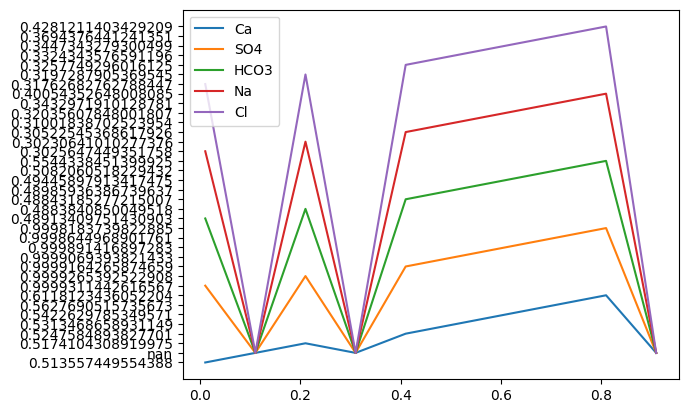

In [38]:
plt.plot(recovery,ca_rej)
plt.plot(recovery,so4_rej)
plt.plot(recovery,hco3_rej)
plt.plot(recovery,na_rej)
plt.plot(recovery,cl_rej)
plt.legend(['Ca', 'SO4', 'HCO3', 'Na', 'Cl'])

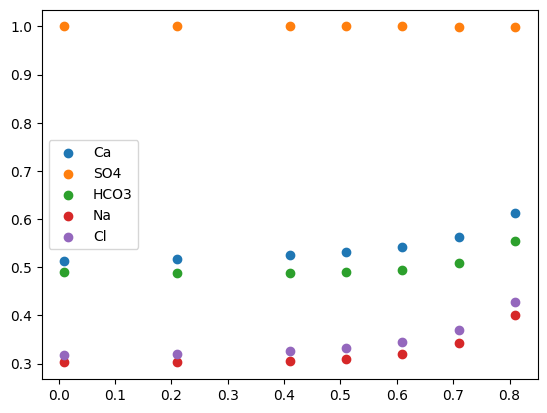

In [35]:
plt.scatter(recovery,ca_rej)
plt.scatter(recovery,so4_rej)
plt.scatter(recovery,hco3_rej)
plt.scatter(recovery,na_rej)
plt.scatter(recovery,cl_rej)
plt.legend(['Ca', 'SO4', 'HCO3', 'Na', 'Cl'])

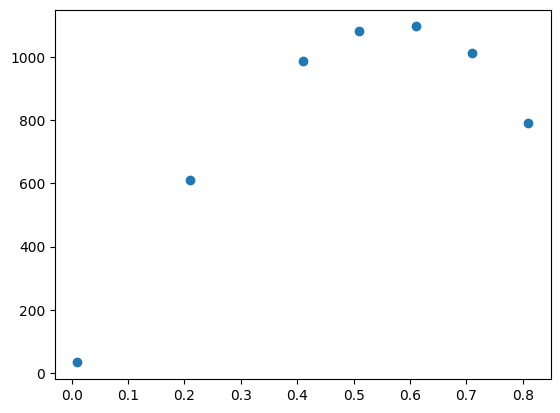

In [36]:
plt.scatter(recovery,arearesults,marker="o")

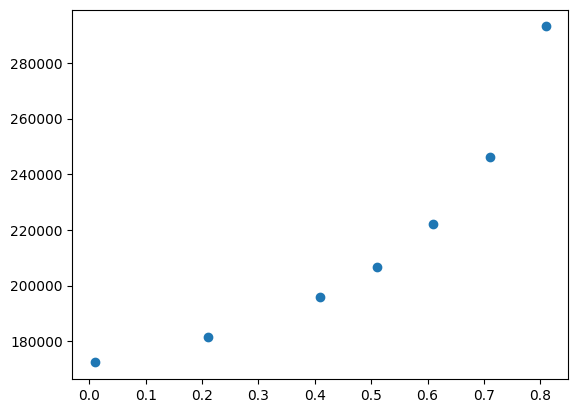

In [37]:
plt.scatter(recovery,pressureresults)